In [1]:
from ingestion import make_cleaned, make_train_test
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error

In [2]:
X_train, X_test, y_train, y_test = make_train_test()

categoric_cols = X_train.select_dtypes(include=object).columns.tolist()
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler())
OH_encoder = SklearnTransformerWrapper(transformer=OneHotEncoder(sparse_output=False, drop='if_binary',min_frequency=0.1,handle_unknown='ignore'), variables=categoric_cols)
pipe = make_pipeline(std_scaler,OH_encoder, ElasticNet(max_iter=2000))
gs = GridSearchCV(n_jobs=3, estimator=pipe, cv=10,scoring='neg_root_mean_squared_error',param_grid={'elasticnet__l1_ratio': [0.7,0.8,0.9,1.0],'elasticnet__alpha': np.arange(0.6,1.5,0.1)})

In [3]:
# Lasso versus Ridge versus ElasticNet
gs.fit(X_train,y_train)

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/s

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15, 16, 22, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14, 15, 31] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/py

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15, 16, 22, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [8, 14, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15, 16, 22, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/pyt

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [8, 14, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/si

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [8, 14, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/pyth

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15, 16, 22, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14, 15, 31] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/pyt

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14, 15, 31] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/pyt

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [14, 15, 31] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 15, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sklearntransformerwrapper-1',
                                        SklearnTransformerWrapper(transformer=StandardScaler())),
                                       ('sklearntransformerwrapper-2',
                                        SklearnTransformerWrapper(transformer=OneHotEncoder(drop='if_binary',
                                                                                            handle_unknown='ignore',
                                                                                            min_frequency=0.1,
                                                                                            sparse_output=False),
                                                                  variables=['MSZoning',
                                                                             'Street',
                                                                             'Alley',
                                                                             'LotShape',
                                                                             'Lan...
                                                                             'BsmtExposure',
                                                                             'BsmtFinType1',
                                                                             'BsmtFinType2',
                                                                             'Heating',
                                                                             'CentralAir',
                                                                             'Electrical',
                                                                             'Functional',
                                                                             'GarageType',
                                                                             'GarageFinish',
                                                                             'PavedDrive',
                                                                             'Fence', ...])),
                                       ('elasticnet',
                                        ElasticNet(max_iter=2000))]),
             n_jobs=3,
             param_grid={'elasticnet__alpha': array([0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4]),
                         'elasticnet__l1_ratio': [0.7, 0.8, 0.9, 1.0]},
             scoring='neg_root_mean_squared_error')

In [4]:
gs.param_grid

{'elasticnet__l1_ratio': [0.7, 0.8, 0.9, 1.0],
 'elasticnet__alpha': array([0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4])}

In [5]:
gs.best_params_

{'elasticnet__alpha': 0.6, 'elasticnet__l1_ratio': 0.8}

In [6]:
min(gs.cv_results_['mean_test_score']*-1)

33137.215195615536

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 14, 15, 16, 17, 22, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 14, 15, 16, 17, 22, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


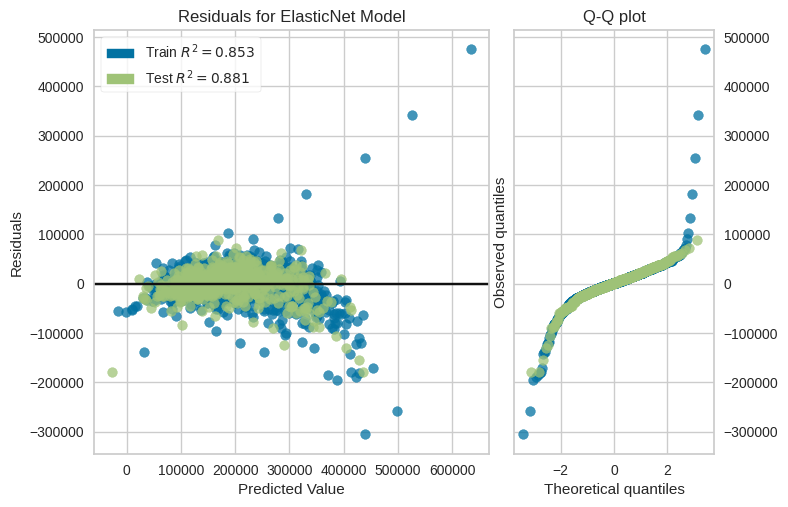

<AxesSubplot: title={'center': 'Residuals for ElasticNet Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [7]:
pipe_final = make_pipeline(std_scaler,OH_encoder,ElasticNet(l1_ratio=0.9,alpha=1.09))
visualizer = ResidualsPlot(pipe_final, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [8]:
pipe_final._final_estimator.coef_

array([-4.99676050e+03,  8.19618292e+00,  2.58907782e+03,  1.38552697e+04,
        4.49179731e+03,  2.32272212e+03,  6.37059537e+02,  6.65911660e+03,
        6.98722661e+03, -1.04017156e+02,  8.02882804e+03,  4.31047964e+03,
        7.18393537e+02, -1.04850183e+02,  4.60584108e+03,  1.44171403e+03,
        5.62530113e+03,  7.31842999e+03, -1.79515986e+02,  1.04598396e+04,
        2.89599166e+03,  2.55053927e+03,  2.00856407e+03, -1.81472947e+03,
        7.32247114e+03,  3.95776548e+03,  4.16325802e+03,  2.52507550e+03,
        2.22999931e+02,  3.54347422e+03,  3.94317396e+03,  1.66572531e+03,
       -4.05521841e+02,  4.05500766e+02,  1.25485964e+02,  2.74506695e+03,
       -6.76150490e+02, -3.83795150e+02, -5.81402268e+03,  1.43765278e+02,
       -7.16322664e+02,  1.13418364e+03, -1.72889549e+03,  5.85717973e+02,
       -4.62434962e+02, -9.52809870e+02,  1.57169215e+03, -1.15703520e+03,
       -4.05635671e+02,  3.41192610e+02, -4.01273806e+02, -1.00137949e+03,
       -1.65906779e+02,  

In [9]:
pipe_final._final_estimator.n_features_in_

108

In [10]:
importances = list(zip(pipe_final._final_estimator.feature_names_in_ , pipe_final._final_estimator.coef_))

In [11]:
importances

[('MSSubClass', -4996.760501474961),
 ('LotFrontage', 8.196182919361323),
 ('LotArea', 2589.077824377046),
 ('OverallQual', 13855.26972646745),
 ('OverallCond', 4491.797310937435),
 ('YearBuilt', 2322.72211815845),
 ('YearRemod/Add', 637.0595371572751),
 ('MasVnrArea', 6659.116596744225),
 ('ExterQual', 6987.226605394914),
 ('ExterCond', -104.01715564046187),
 ('BsmtQual', 8028.8280398536135),
 ('BsmtFinSF1', 4310.479640987308),
 ('BsmtFinSF2', 718.3935368297739),
 ('BsmtUnfSF', -104.85018261012476),
 ('TotalBsmtSF', 4605.841077456913),
 ('HeatingQC', 1441.7140342181851),
 ('1stFlrSF', 5625.301128314274),
 ('2ndFlrSF', 7318.429992893008),
 ('LowQualFinSF', -179.51598564201973),
 ('GrLivArea', 10459.839642974137),
 ('BsmtFullBath', 2895.9916591413544),
 ('FullBath', 2550.5392744921037),
 ('HalfBath', 2008.56407082829),
 ('BedroomAbvGr', -1814.7294693565418),
 ('KitchenQual', 7322.471136924245),
 ('TotRmsAbvGrd', 3957.765484297561),
 ('Fireplaces', 4163.258020402975),
 ('FireplaceQu', 25

In [12]:
rmse_test = mean_squared_error(pipe_final.predict(X_test),y_test, squared=False)
print(f"rmse = {rmse_test}")

rmse = 26848.955406592602


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 14, 15, 16, 17, 22, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
